Masks saved in directory: output_masks


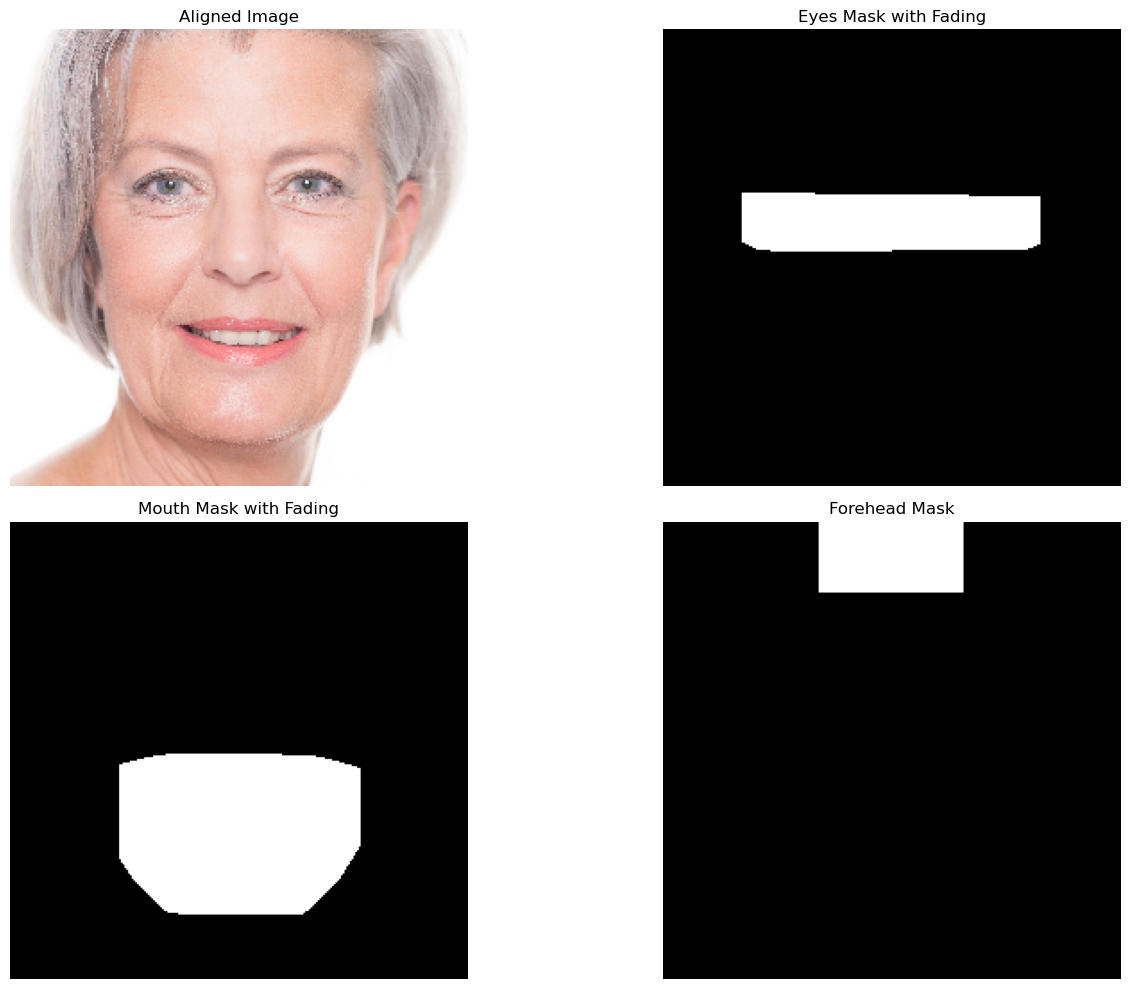

Combined mask saved as 'output_masks/combined_mask.png'
HTTPSConnectionPool(host='api.modelslab.com', port=443): Max retries exceeded with url: /inpaint (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002304873C080>: Failed to resolve 'api.modelslab.com' ([Errno 11001] getaddrinfo failed)"))


In [55]:
import cv2
import dlib
import numpy as np
import imutils
from imutils import face_utils
import math
import os
import matplotlib.pyplot as plt
import requests  # For making API calls

# Initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')  # Ensure the path is correct

# Load the image
image_path = '1 (2789).jpg'  # Replace with your image path
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found or unable to load.")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
rects = detector(gray, 1)

if len(rects) == 0:
    raise ValueError("No faces detected in the image.")

# For simplicity, we'll process the first detected face
rect = rects[0]

# Determine the facial landmarks for the face region
shape = predictor(gray, rect)
shape = face_utils.shape_to_np(shape)  # Convert to NumPy array


def align_face(image, landmarks):
    # Define desired positions for left eye, right eye, and nose
    desired_left_eye = (0.35, 0.35)
    desired_face_width = 256
    desired_face_height = 256

    # Extract the left and right eye coordinates
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks[lStart:lEnd]
    rightEyePts = landmarks[rStart:rEnd]

    # Compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0)
    rightEyeCenter = rightEyePts.mean(axis=0)

    # Compute the angle between the eye centroids
    dy = rightEyeCenter[1] - leftEyeCenter[1]
    dx = rightEyeCenter[0] - leftEyeCenter[0]
    angle = math.degrees(math.atan2(dy, dx)) - 180

    # Compute the desired right eye x-coordinate based on desired left eye x-coordinate
    desired_right_eye_x = 1.0 - desired_left_eye[0]

    # Determine the scale of the new face
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = (desired_right_eye_x - desired_left_eye[0]) * desired_face_width
    scale = desired_dist / dist

    # Compute center between the two eyes as floating-point numbers
    eyes_center = ((leftEyeCenter[0] + rightEyeCenter[0]) / 2.0,
                   (leftEyeCenter[1] + rightEyeCenter[1]) / 2.0)

    # Get the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # Update the translation component of the matrix
    tX = desired_face_width * 0.5
    tY = desired_face_height * desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # Apply the affine transformation
    aligned_face = cv2.warpAffine(image, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)

    return aligned_face, M


# Align the face
aligned_image, transformation_matrix = align_face(image, shape)

# Optionally, display the aligned face
# cv2.imshow("Aligned Face", aligned_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


def get_landmarks(aligned_image, M, original_landmarks):
    # Transform the original landmarks
    ones = np.ones((original_landmarks.shape[0], 1))
    landmarks_homogeneous = np.hstack([original_landmarks, ones])
    transformed_landmarks = M.dot(landmarks_homogeneous.T).T
    return transformed_landmarks


landmarks_aligned = get_landmarks(aligned_image, transformation_matrix, shape)


def get_face_contour(aligned_image, landmarks_aligned):
    # Define the facial contour points (points 0 to 16)
    contour_pts = landmarks_aligned[0:17].astype(int)

    # Create a mask for the face contour
    mask_contour = np.zeros(aligned_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask_contour, [contour_pts], 255)

    return mask_contour


mask_contour = get_face_contour(aligned_image, landmarks_aligned)


def create_directional_constraint(shape, direction='down'):
    # Create an empty mask
    constraint = np.zeros(shape, dtype=np.uint8)

    h, w = shape

    if direction == 'down':
        # Allow fading only in the lower half of the mask
        constraint[h // 2:h, :] = 255
    elif direction == 'up':
        # Allow fading only in the upper half of the mask
        constraint[0:h // 2, :] = 255
    elif direction == 'left':
        constraint[:, 0:w // 2] = 255
    elif direction == 'right':
        constraint[:, w // 2:w] = 255
    elif direction == 'horizontal':
        constraint[:, :] = 255
    elif direction == 'vertical':
        constraint[:, :] = 255
    else:
        constraint[:, :] = 255  # No constraint

    return constraint


def apply_directional_fade(mask, direction='down', fade_size=30):
    # Create a kernel for dilation
    kernel = np.ones((3, 3), np.uint8)

    # Initialize the faded mask
    faded_mask = mask.copy()

    # Apply multiple dilations with decreasing intensity to create a fading effect
    for i in range(1, fade_size + 1):
        # Dilate the mask
        dilated = cv2.dilate(mask, kernel, iterations=1)

        # Create a mask for this iteration
        temp_mask = cv2.subtract(dilated, mask)

        # Create a weighted mask
        weight = 1 - (i / (fade_size + 1))
        faded = (temp_mask.astype(float) * weight).astype(np.uint8)

        # Apply directional constraints
        if direction == 'down':
            # Create a directional mask that only allows fading downwards
            directional_mask = create_directional_constraint(mask.shape, direction='down')
            faded = cv2.bitwise_and(faded, directional_mask)
        elif direction == 'up':
            directional_mask = create_directional_constraint(mask.shape, direction='up')
            faded = cv2.bitwise_and(faded, directional_mask)
        # Add more directions if needed

        # Add the faded region to the overall faded mask
        faded_mask = cv2.max(faded_mask, faded)

        # Update the mask for the next iteration
        mask = dilated.copy()

    # Combine the original mask with the faded mask
    combined_mask = cv2.add(mask, faded_mask)

    # Normalize the mask to range [0, 255]
    combined_mask = cv2.normalize(combined_mask, None, 0, 255, cv2.NORM_MINMAX)

    return combined_mask


def create_fading_mask(aligned_image, landmarks_aligned, mask_contour):
    mask_eye = np.zeros(aligned_image.shape[:2], dtype=np.uint8)
    mask_mouth = np.zeros(aligned_image.shape[:2], dtype=np.uint8)

    # Eyes
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks_aligned[lStart:lEnd].astype(int)
    rightEyePts = landmarks_aligned[rStart:rEnd].astype(int)

    # Draw eyes on mask_eye
    cv2.fillPoly(mask_eye, [leftEyePts], 255)
    cv2.fillPoly(mask_eye, [rightEyePts], 255)

    # Mouth
    (mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
    mouthPts = landmarks_aligned[mStart:mEnd].astype(int)
    cv2.fillPoly(mask_mouth, [mouthPts], 255)

    # Apply directional fading to eyes and mouth
    mask_eye_faded = apply_directional_fade(mask_eye, direction='down', fade_size=30)
    mask_mouth_faded = apply_directional_fade(mask_mouth, direction='down', fade_size=30)

    # Ensure masks don't exceed facial boundaries
    mask_eye_faded = cv2.bitwise_and(mask_eye_faded, mask_contour)
    mask_mouth_faded = cv2.bitwise_and(mask_mouth_faded, mask_contour)

    return mask_eye_faded, mask_mouth_faded


def create_forehead_mask(aligned_image, landmarks_aligned):
    mask_forehead = np.zeros(aligned_image.shape[:2], dtype=np.uint8)

    # Define forehead region based on eye landmarks
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks_aligned[lStart:lEnd].astype(int)
    rightEyePts = landmarks_aligned[rStart:rEnd].astype(int)

    # Calculate eye center as midpoint between the left and right eye centers
    left_eye_center = leftEyePts.mean(axis=0).astype(int)
    right_eye_center = rightEyePts.mean(axis=0).astype(int)
    eye_center = ((left_eye_center + right_eye_center) // 2).astype(int)

    # Define forehead rectangle above the eyes
    forehead_height = 40  # Adjust as needed
    forehead_width = 80    # Adjust as needed

    top_left = (eye_center[0] - forehead_width // 2, eye_center[1] - forehead_height - 50)
    bottom_right = (eye_center[0] + forehead_width // 2, eye_center[1] - 50)

    # Draw forehead mask
    cv2.rectangle(mask_forehead, top_left, bottom_right, 255, -1)

    return mask_forehead


def save_masks(aligned_image, mask_eye_faded, mask_mouth_faded, mask_forehead, output_dir='output_masks'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save masks
    cv2.imwrite(os.path.join(output_dir, 'mask_eye_faded.png'), mask_eye_faded)
    cv2.imwrite(os.path.join(output_dir, 'mask_mouth_faded.png'), mask_mouth_faded)
    cv2.imwrite(os.path.join(output_dir, 'mask_forehead.png'), mask_forehead)

    print(f"Masks saved in directory: {output_dir}")


def visualize_masks(aligned_image, mask_eye_faded, mask_mouth_faded, mask_forehead):
    aligned_image_rgb = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(aligned_image_rgb)
    plt.title('Aligned Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(mask_eye_faded, cmap='gray')
    plt.title('Eyes Mask with Fading')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(mask_mouth_faded, cmap='gray')
    plt.title('Mouth Mask with Fading')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(mask_forehead, cmap='gray')
    plt.title('Forehead Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Create masks for eyes and mouth with fading
mask_eye_faded, mask_mouth_faded = create_fading_mask(aligned_image, landmarks_aligned, mask_contour)

# Create mask for forehead
mask_forehead = create_forehead_mask(aligned_image, landmarks_aligned)

# Save the masks
save_masks(aligned_image, mask_eye_faded, mask_mouth_faded, mask_forehead)

# Visualize the masks
# visualize_masks(aligned_image, mask_eye_faded, mask_mouth_faded, mask_forehead)


def perform_inpainting(aligned_image, combined_mask, modelslab_api_url, api_key=None):
    """
    Perform inpainting using ModelsLab's Inpainting API.

    Parameters:
    - aligned_image: The aligned face image (numpy array).
    - combined_mask: The combined mask for inpainting (numpy array).
    - modelslab_api_url: The API endpoint URL for ModelsLab's inpainting.
    - api_key: (Optional) API key for authentication.

    Returns:
    - inpainted_image: The resulting inpainted image (numpy array).
    """
    # Encode the image and mask as PNG
    _, img_encoded = cv2.imencode('.png', aligned_image)
    _, mask_encoded = cv2.imencode('.png', combined_mask)

    # Prepare the payload
    files = {
        'image': ('aligned_image.png', img_encoded.tobytes(), 'image/png'),
        'mask': ('mask.png', mask_encoded.tobytes(), 'image/png')
    }

    headers = {}
    if api_key:
        headers['Authorization'] = f'Bearer {api_key}'

    # Send the POST request to the ModelsLab Inpainting API
    response = requests.post(modelslab_api_url, files=files, headers=headers)

    if response.status_code == 200:
        # Decode the inpainted image from the response
        inpainted_image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
        return inpainted_image
    else:
        raise Exception(f"Inpainting failed with status code {response.status_code}: {response.text}")


def combine_masks(mask_eye, mask_mouth, mask_forehead):
    # Combine masks using bitwise OR
    combined_mask = cv2.bitwise_or(mask_eye, mask_mouth)
    combined_mask = cv2.bitwise_or(combined_mask, mask_forehead)
    return combined_mask


def show_before_after(aligned_image, inpainted_image):
    aligned_image_rgb = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)
    inpainted_image_rgb = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(aligned_image_rgb)
    plt.title('Before Inpainting')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(inpainted_image_rgb)
    plt.title('After Inpainting')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Combine masks into a single mask
combined_mask = combine_masks(mask_eye_faded, mask_mouth_faded, mask_forehead)

# Optionally, save the combined mask
cv2.imwrite('output_masks/combined_mask.png', combined_mask)
print("Combined mask saved as 'output_masks/combined_mask.png'")

# Define ModelsLab's Inpainting API details
modelslab_api_url = 'https://api.modelslab.com/inpaint'  # Replace with actual API URL
api_key = 'YOUR_MODELSLAB_API_KEY'  # Replace with your actual API key, if required

# Perform inpainting
try:
    inpainted_image = perform_inpainting(aligned_image, combined_mask, modelslab_api_url, api_key)
    # Save the inpainted image
    inpainted_image_path = 'output_masks/inpainted_face.png'
    cv2.imwrite(inpainted_image_path, inpainted_image)
    print(f"Inpainted image saved as '{inpainted_image_path}'")
except Exception as e:
    print(str(e))

# Show before and after images
if 'inpainted_image' in locals():
    show_before_after(aligned_image, inpainted_image)


Masks saved in directory: 'output_masks'


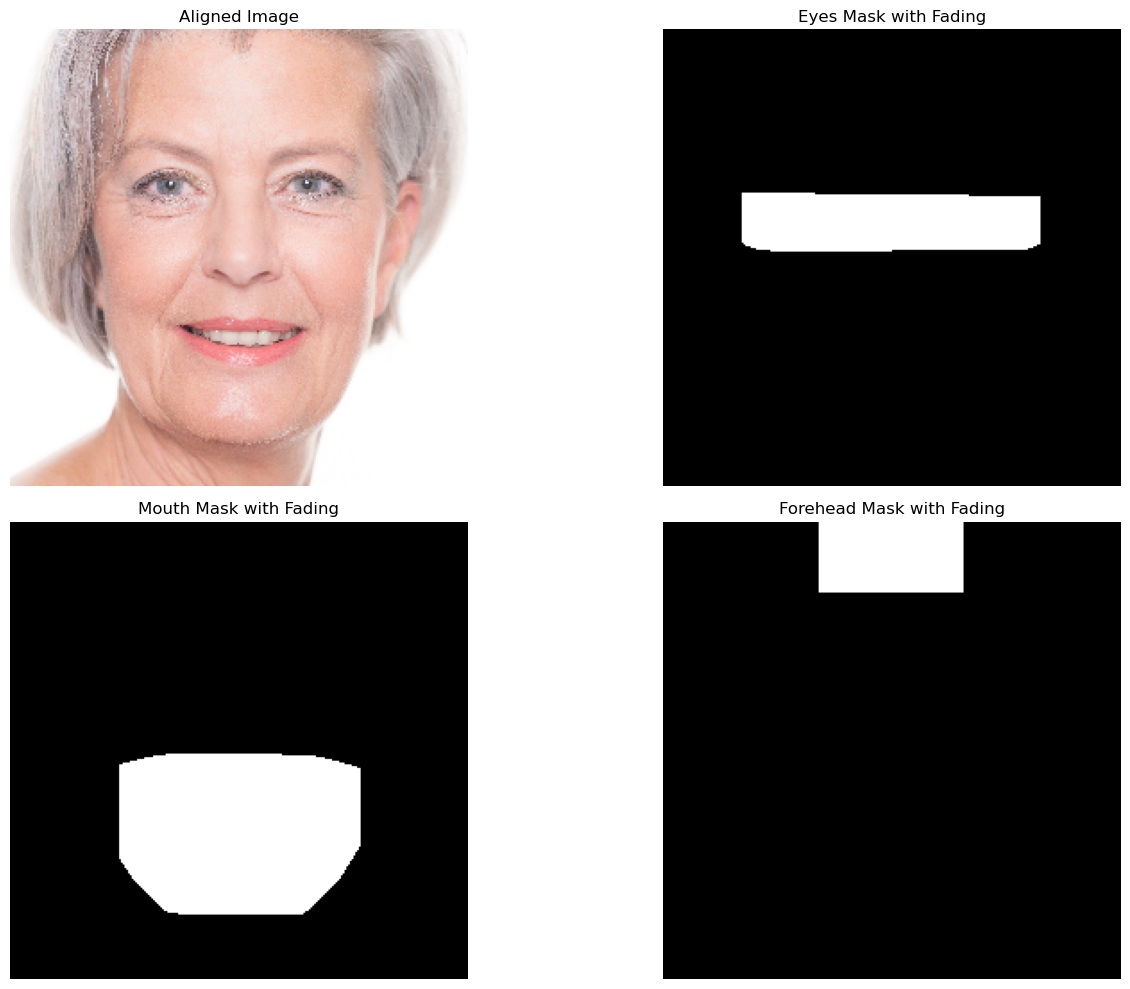

Sending inpainting request to Modelslab's Inpainting API...


ConnectionError: HTTPSConnectionPool(host='api.modelslab.com', port=443): Max retries exceeded with url: /v1/inpaint (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002300006CBF0>: Failed to resolve 'api.modelslab.com' ([Errno 11001] getaddrinfo failed)"))

In [57]:
import cv2
import dlib
import numpy as np
import imutils
from imutils import face_utils
import math
import os
import matplotlib.pyplot as plt
import requests  # For making API calls

# Suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore")

# ==========================
# Configuration Parameters
# ==========================

# Paths
PREDICTOR_PATH = 'shape_predictor_68_face_landmarks.dat'  # Ensure this file is in your working directory
IMAGE_PATH = '1 (2789).jpg'  # Replace with your image path
OUTPUT_DIR = 'output_masks'

# Modelslab Inpainting API Details
MODELSLAB_API_URL = 'https://api.modelslab.com/v1/inpaint'  # Replace with the actual API endpoint
API_KEY = 'YOUR_MODELSLAB_API_KEY'  # Replace with your actual API key

# Inpainting Parameters
FADE_SIZE = 30
FORGET_RADIUS = 3  # OpenCV inpainting radius (if needed for alternative)

# ==========================
# Helper Functions
# ==========================

def align_face(image, landmarks):
    """
    Aligns the face in the image based on eye positions.
    """
    desired_left_eye = (0.35, 0.35)
    desired_face_width = 256
    desired_face_height = 256

    # Extract the left and right eye coordinates
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks[lStart:lEnd]
    rightEyePts = landmarks[rStart:rEnd]

    # Compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

    # Compute the angle between the eye centroids
    dy = rightEyeCenter[1] - leftEyeCenter[1]
    dx = rightEyeCenter[0] - leftEyeCenter[0]
    angle = math.degrees(math.atan2(dy, dx)) - 180

    # Compute the desired right eye x-coordinate based on desired left eye x-coordinate
    desired_right_eye_x = 1.0 - desired_left_eye[0]

    # Determine the scale of the new face
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = (desired_right_eye_x - desired_left_eye[0]) * desired_face_width
    scale = desired_dist / dist

    # Compute center between the two eyes
    eyes_center = ((leftEyeCenter[0] + rightEyeCenter[0]) / 2.0,
                   (leftEyeCenter[1] + rightEyeCenter[1]) / 2.0)

    # Get the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # Update the translation component of the matrix
    tX = desired_face_width * 0.5
    tY = desired_face_height * desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # Apply the affine transformation
    aligned_face = cv2.warpAffine(image, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)

    return aligned_face, M

def get_landmarks(aligned_image, M, original_landmarks):
    """
    Transforms the original landmarks to the aligned image's coordinate system.
    """
    ones = np.ones((original_landmarks.shape[0], 1))
    landmarks_homogeneous = np.hstack([original_landmarks, ones])
    transformed_landmarks = M.dot(landmarks_homogeneous.T).T
    return transformed_landmarks

def get_face_contour(aligned_image, landmarks_aligned):
    """
    Creates a mask for the facial contour using jawline landmarks.
    """
    contour_pts = landmarks_aligned[0:17].astype(int)  # Jawline points
    mask_contour = np.zeros(aligned_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask_contour, [contour_pts], 255)
    return mask_contour

def create_directional_constraint(shape, direction='down'):
    """
    Creates a directional constraint mask to control the direction of fading.
    """
    constraint = np.zeros(shape, dtype=np.uint8)
    h, w = shape

    if direction == 'down':
        constraint[h//2:h, :] = 255
    elif direction == 'up':
        constraint[0:h//2, :] = 255
    elif direction == 'left':
        constraint[:, 0:w//2] = 255
    elif direction == 'right':
        constraint[:, w//2:w] = 255
    elif direction in ['horizontal', 'vertical']:
        constraint[:, :] = 255
    else:
        constraint[:, :] = 255  # No constraint

    return constraint

def apply_directional_fade(mask, direction='down', fade_size=30):
    """
    Applies directional fading to a mask.
    """
    kernel = np.ones((3,3), np.uint8)
    faded_mask = mask.copy()

    for i in range(1, fade_size+1):
        dilated = cv2.dilate(mask, kernel, iterations=1)
        temp_mask = cv2.subtract(dilated, mask)
        weight = 1 - (i / (fade_size + 1))
        faded = (temp_mask.astype(float) * weight).astype(np.uint8)

        if direction in ['down', 'up']:
            directional_mask = create_directional_constraint(mask.shape, direction=direction)
            faded = cv2.bitwise_and(faded, directional_mask)

        faded_mask = cv2.max(faded_mask, faded)
        mask = dilated.copy()

    combined_mask = cv2.add(mask, faded_mask)
    combined_mask = cv2.normalize(combined_mask, None, 0, 255, cv2.NORM_MINMAX)

    return combined_mask

def create_fading_mask(aligned_image, landmarks_aligned, mask_contour, fade_size=30):
    """
    Creates fading masks for eyes and mouth.
    """
    mask_eye = np.zeros(aligned_image.shape[:2], dtype=np.uint8)
    mask_mouth = np.zeros(aligned_image.shape[:2], dtype=np.uint8)

    # Eyes
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks_aligned[lStart:lEnd].astype(int)
    rightEyePts = landmarks_aligned[rStart:rEnd].astype(int)

    cv2.fillPoly(mask_eye, [leftEyePts], 255)
    cv2.fillPoly(mask_eye, [rightEyePts], 255)

    # Mouth
    (mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
    mouthPts = landmarks_aligned[mStart:mEnd].astype(int)
    cv2.fillPoly(mask_mouth, [mouthPts], 255)

    # Apply directional fading
    mask_eye_faded = apply_directional_fade(mask_eye, direction='down', fade_size=fade_size)
    mask_mouth_faded = apply_directional_fade(mask_mouth, direction='down', fade_size=fade_size)

    # Ensure masks don't exceed facial boundaries
    mask_eye_faded = cv2.bitwise_and(mask_eye_faded, mask_contour)
    mask_mouth_faded = cv2.bitwise_and(mask_mouth_faded, mask_contour)

    return mask_eye_faded, mask_mouth_faded

def create_forehead_mask(aligned_image, landmarks_aligned):
    mask_forehead = np.zeros(aligned_image.shape[:2], dtype=np.uint8)

    # Define forehead region based on eye landmarks
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks_aligned[lStart:lEnd].astype(int)
    rightEyePts = landmarks_aligned[rStart:rEnd].astype(int)

    # Calculate eye center as midpoint between the left and right eye centers
    left_eye_center = leftEyePts.mean(axis=0).astype(int)
    right_eye_center = rightEyePts.mean(axis=0).astype(int)
    eye_center = ((left_eye_center + right_eye_center) // 2).astype(int)

    # Define forehead rectangle above the eyes
    forehead_height = 40  # Adjust as needed
    forehead_width = 80    # Adjust as needed

    top_left = (eye_center[0] - forehead_width // 2, eye_center[1] - forehead_height - 50)
    bottom_right = (eye_center[0] + forehead_width // 2, eye_center[1] - 50)

    # Draw forehead mask
    cv2.rectangle(mask_forehead, top_left, bottom_right, 255, -1)

    return mask_forehead


def combine_masks(mask_eye, mask_mouth, mask_forehead):
    """
    Combines individual masks into a single mask.
    """
    combined_mask = cv2.bitwise_or(mask_eye, mask_mouth)
    combined_mask = cv2.bitwise_or(combined_mask, mask_forehead)
    return combined_mask

def save_masks(mask_eye_faded, mask_mouth_faded, mask_forehead_faded, combined_mask, output_dir='output_masks'):
    """
    Saves the individual and combined masks to the specified directory.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cv2.imwrite(os.path.join(output_dir, 'mask_eye_faded.png'), mask_eye_faded)
    cv2.imwrite(os.path.join(output_dir, 'mask_mouth_faded.png'), mask_mouth_faded)
    cv2.imwrite(os.path.join(output_dir, 'mask_forehead_faded.png'), mask_forehead_faded)
    cv2.imwrite(os.path.join(output_dir, 'combined_mask.png'), combined_mask)

    print(f"Masks saved in directory: '{output_dir}'")

def visualize_masks(aligned_image, mask_eye_faded, mask_mouth_faded, mask_forehead_faded):
    """
    Displays the aligned image and masks for verification.
    """
    aligned_image_rgb = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(aligned_image_rgb)
    plt.title('Aligned Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(mask_eye_faded, cmap='gray')
    plt.title('Eyes Mask with Fading')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(mask_mouth_faded, cmap='gray')
    plt.title('Mouth Mask with Fading')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(mask_forehead_faded, cmap='gray')
    plt.title('Forehead Mask with Fading')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def perform_inpainting_modelslab(aligned_image, combined_mask, api_url, api_key):
    """
    Performs inpainting using Modelslab's Inpainting API.
    """
    # Encode the image and mask as PNG
    _, img_encoded = cv2.imencode('.png', aligned_image)
    _, mask_encoded = cv2.imencode('.png', combined_mask)

    # Prepare the multipart/form-data payload
    files = {
        'image': ('aligned_image.png', img_encoded.tobytes(), 'image/png'),
        'mask': ('mask.png', mask_encoded.tobytes(), 'image/png')
    }

    headers = {
        'Authorization': f'Bearer {api_key}'  # If API key is required in headers
    }

    print("Sending inpainting request to Modelslab's Inpainting API...")

    # Send the POST request
    response = requests.post(api_url, files=files, headers=headers)

    if response.status_code == 200:
        # Assuming the API returns the inpainted image directly
        inpainted_image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
        print("Inpainting successful.")
        return inpainted_image
    else:
        print(f"Inpainting failed with status code {response.status_code}: {response.text}")
        return None

def show_before_after(aligned_image, inpainted_image):
    """
    Displays the original and inpainted images side by side.
    """
    aligned_image_rgb = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)
    inpainted_image_rgb = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(aligned_image_rgb)
    plt.title('Before Inpainting')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(inpainted_image_rgb)
    plt.title('After Inpainting')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ==========================
# Main Processing
# ==========================

def main():
    # Check if predictor file exists
    if not os.path.exists(PREDICTOR_PATH):
        raise FileNotFoundError(f"Facial landmark predictor not found at '{PREDICTOR_PATH}'. Please download it from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 and extract it.")

    # Load the image
    image = cv2.imread(IMAGE_PATH)
    if image is None:
        raise ValueError(f"Image not found or unable to load at '{IMAGE_PATH}'.")

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    rects = detector(gray, 1)
    if len(rects) == 0:
        raise ValueError("No faces detected in the image.")

    # Process the first detected face
    rect = rects[0]
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)  # Convert to NumPy array

    # Align the face
    aligned_image, transformation_matrix = align_face(image, shape)

    # Transform landmarks to aligned image
    landmarks_aligned = get_landmarks(aligned_image, transformation_matrix, shape)

    # Create face contour mask
    mask_contour = get_face_contour(aligned_image, landmarks_aligned)

    # Create masks for eyes and mouth with fading
    mask_eye_faded, mask_mouth_faded = create_fading_mask(aligned_image, landmarks_aligned, mask_contour, fade_size=FADE_SIZE)

    # Create mask for forehead with fading
    mask_forehead_faded = create_forehead_mask(aligned_image, landmarks_aligned)

    # Combine all masks
    combined_mask = combine_masks(mask_eye_faded, mask_mouth_faded, mask_forehead_faded)

    # Save the masks
    save_masks(mask_eye_faded, mask_mouth_faded, mask_forehead_faded, combined_mask, output_dir=OUTPUT_DIR)

    # Visualize the masks
    visualize_masks(aligned_image, mask_eye_faded, mask_mouth_faded, mask_forehead_faded)

    # Perform inpainting using Modelslab's Inpainting API
    inpainted_image = perform_inpainting_modelslab(aligned_image, combined_mask, MODELSLAB_API_URL, API_KEY)

    if inpainted_image is not None:
        # Save the inpainted image
        inpainted_image_path = os.path.join(OUTPUT_DIR, 'inpainted_face_modelslab.png')
        cv2.imwrite(inpainted_image_path, inpainted_image)
        print(f"Inpainted image saved as '{inpainted_image_path}'")

        # Show before and after images
        show_before_after(aligned_image, inpainted_image)
    else:
        print("Inpainting was not successful.")

if __name__ == "__main__":
    main()


Masks saved in directory: 'output_masks'


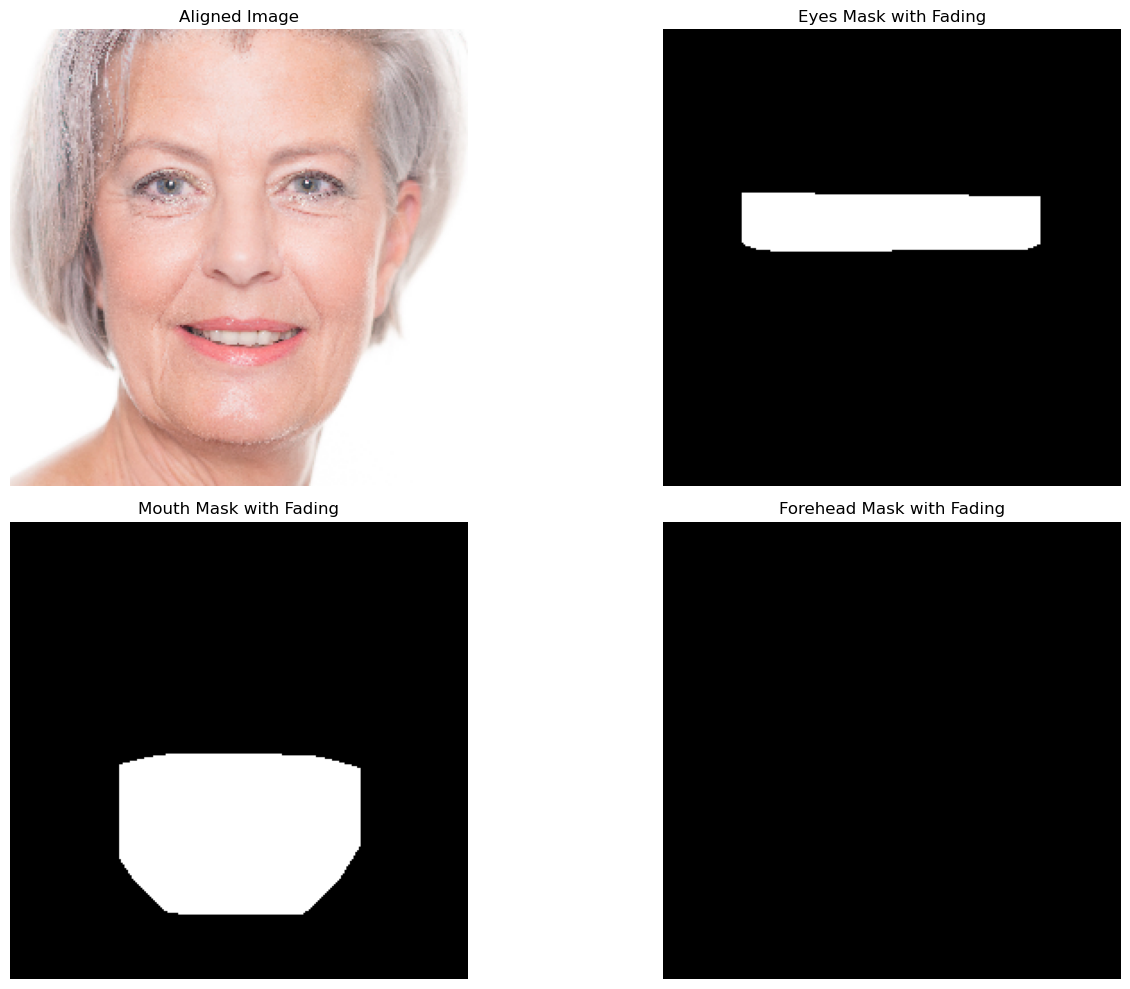

Uploading 'output_masks\aligned_face.png' to Imgur...
Failed to upload image to Imgur. Status Code: 429, Response: {"errors":[{"id":"legacy-api-fbf8d4495-bwjhn/4FYQct7AmH-11378322","code":"429","status":"Too Many Requests","detail":"Too Many Requests"}]}

Uploading 'output_masks\combined_mask.png' to Imgur...
Failed to upload image to Imgur. Status Code: 429, Response: {"errors":[{"id":"legacy-api-fbf8d4495-94dsf/PAMD5Xz17O-11378524","code":"429","status":"Too Many Requests","detail":"Too Many Requests"}]}

Failed to upload images to Imgur. Cannot proceed with inpainting.


In [58]:
import cv2
import dlib
import numpy as np
import imutils
from imutils import face_utils
import math
import os
import matplotlib.pyplot as plt
import requests  # For making API calls

# Suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore")

# ==========================
# Configuration Parameters
# ==========================

# Paths
PREDICTOR_PATH = 'shape_predictor_68_face_landmarks.dat'  # Ensure this file is in your working directory
IMAGE_PATH = '1 (2789).jpg'  # Replace with your image path
OUTPUT_DIR = 'output_masks'

# Modelslab Inpainting API Details
MODELSLAB_API_URL = 'https://modelslab.com/api/v6/image_editing/inpaint'  # Correct API endpoint
MODELSLAB_API_KEY = 'YOUR_MODELSLAB_API_KEY'  # Replace with your actual Modelslab API key

# Imgur API Details for Image Uploading
IMGUR_CLIENT_ID = 'YOUR_IMGUR_CLIENT_ID'  # Replace with your actual Imgur Client ID

# Inpainting Parameters
FADE_SIZE = 30
INPAINT_RADIUS = 3  # Radius for inpainting
INPAINT_METHOD = cv2.INPAINT_TELEA  # Choose between cv2.INPAINT_TELEA and cv2.INPAINT_NS

# ==========================
# Helper Functions
# ==========================

def align_face(image, landmarks):
    """
    Aligns the face in the image based on eye positions.
    """
    desired_left_eye = (0.35, 0.35)
    desired_face_width = 256
    desired_face_height = 256

    # Extract the left and right eye coordinates
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks[lStart:lEnd]
    rightEyePts = landmarks[rStart:rEnd]

    # Compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

    # Compute the angle between the eye centroids
    dy = rightEyeCenter[1] - leftEyeCenter[1]
    dx = rightEyeCenter[0] - leftEyeCenter[0]
    angle = math.degrees(math.atan2(dy, dx)) - 180

    # Compute the desired right eye x-coordinate based on desired left eye x-coordinate
    desired_right_eye_x = 1.0 - desired_left_eye[0]

    # Determine the scale of the new face
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = (desired_right_eye_x - desired_left_eye[0]) * desired_face_width
    scale = desired_dist / dist

    # Compute center between the two eyes
    eyes_center = ((leftEyeCenter[0] + rightEyeCenter[0]) / 2.0,
                   (leftEyeCenter[1] + rightEyeCenter[1]) / 2.0)

    # Get the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # Update the translation component of the matrix
    tX = desired_face_width * 0.5
    tY = desired_face_height * desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # Apply the affine transformation
    aligned_face = cv2.warpAffine(image, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)

    return aligned_face, M

def get_landmarks(aligned_image, M, original_landmarks):
    """
    Transforms the original landmarks to the aligned image's coordinate system.
    """
    ones = np.ones((original_landmarks.shape[0], 1))
    landmarks_homogeneous = np.hstack([original_landmarks, ones])
    transformed_landmarks = M.dot(landmarks_homogeneous.T).T
    return transformed_landmarks

def get_face_contour(aligned_image, landmarks_aligned):
    """
    Creates a mask for the facial contour using jawline landmarks.
    """
    contour_pts = landmarks_aligned[0:17].astype(int)  # Jawline points
    mask_contour = np.zeros(aligned_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask_contour, [contour_pts], 255)
    return mask_contour

def create_directional_constraint(shape, direction='down'):
    """
    Creates a directional constraint mask to control the direction of fading.
    """
    constraint = np.zeros(shape, dtype=np.uint8)
    h, w = shape

    if direction == 'down':
        constraint[h//2:h, :] = 255
    elif direction == 'up':
        constraint[0:h//2, :] = 255
    elif direction == 'left':
        constraint[:, 0:w//2] = 255
    elif direction == 'right':
        constraint[:, w//2:w] = 255
    elif direction in ['horizontal', 'vertical']:
        constraint[:, :] = 255
    else:
        constraint[:, :] = 255  # No constraint

    return constraint

def apply_directional_fade(mask, direction='down', fade_size=30):
    """
    Applies directional fading to a mask.
    """
    kernel = np.ones((3,3), np.uint8)
    faded_mask = mask.copy()

    for i in range(1, fade_size+1):
        dilated = cv2.dilate(mask, kernel, iterations=1)
        temp_mask = cv2.subtract(dilated, mask)
        weight = 1 - (i / (fade_size + 1))
        faded = (temp_mask.astype(float) * weight).astype(np.uint8)

        if direction in ['down', 'up']:
            directional_mask = create_directional_constraint(mask.shape, direction=direction)
            faded = cv2.bitwise_and(faded, directional_mask)

        faded_mask = cv2.max(faded_mask, faded)
        mask = dilated.copy()

    combined_mask = cv2.add(mask, faded_mask)
    combined_mask = cv2.normalize(combined_mask, None, 0, 255, cv2.NORM_MINMAX)

    return combined_mask

def create_fading_mask(aligned_image, landmarks_aligned, mask_contour, fade_size=30):
    """
    Creates fading masks for eyes and mouth.
    """
    mask_eye = np.zeros(aligned_image.shape[:2], dtype=np.uint8)
    mask_mouth = np.zeros(aligned_image.shape[:2], dtype=np.uint8)

    # Eyes
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks_aligned[lStart:lEnd].astype(int)
    rightEyePts = landmarks_aligned[rStart:rEnd].astype(int)

    cv2.fillPoly(mask_eye, [leftEyePts], 255)
    cv2.fillPoly(mask_eye, [rightEyePts], 255)

    # Mouth
    (mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
    mouthPts = landmarks_aligned[mStart:mEnd].astype(int)
    cv2.fillPoly(mask_mouth, [mouthPts], 255)

    # Apply directional fading
    mask_eye_faded = apply_directional_fade(mask_eye, direction='down', fade_size=fade_size)
    mask_mouth_faded = apply_directional_fade(mask_mouth, direction='down', fade_size=fade_size)

    # Ensure masks don't exceed facial boundaries
    mask_eye_faded = cv2.bitwise_and(mask_eye_faded, mask_contour)
    mask_mouth_faded = cv2.bitwise_and(mask_mouth_faded, mask_contour)

    return mask_eye_faded, mask_mouth_faded

def create_forehead_mask(aligned_image, landmarks_aligned, mask_contour, fade_size=30):
    """
    Creates a mask for the forehead region.
    """
    mask_forehead = np.zeros(aligned_image.shape[:2], dtype=np.uint8)

    # Eyebrow landmarks to approximate forehead
    (leStart, leEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
    (reStart, reEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
    left_eyebrow = landmarks_aligned[leStart:leEnd].astype(int)
    right_eyebrow = landmarks_aligned[reStart:reEnd].astype(int)

    # Center point between eyebrows
    eyebrows_center = ((left_eyebrow.mean(axis=0) + right_eyebrow.mean(axis=0)) / 2).astype(int)

    # Forehead rectangle parameters
    forehead_width = 80  # Adjust as needed
    forehead_height = 40  # Adjust as needed

    top_left = (int(eyebrows_center[0] - forehead_width / 2), int(eyebrows_center[1] - forehead_height - 10))
    bottom_right = (int(eyebrows_center[0] + forehead_width / 2), int(eyebrows_center[1] - 10))

    # Draw the forehead rectangle
    cv2.rectangle(mask_forehead, top_left, bottom_right, 255, -1)

    # Apply Gaussian blur to soften edges
    mask_forehead = cv2.GaussianBlur(mask_forehead, (21, 21), 0)

    # Ensure the forehead mask doesn't exceed facial boundaries
    mask_forehead = cv2.bitwise_and(mask_forehead, mask_contour)

    # Optionally, apply directional fading to the forehead
    mask_forehead_faded = apply_directional_fade(mask_forehead, direction='down', fade_size=fade_size)

    return mask_forehead_faded

def combine_masks(mask_eye, mask_mouth, mask_forehead):
    """
    Combines individual masks into a single mask.
    """
    combined_mask = cv2.bitwise_or(mask_eye, mask_mouth)
    combined_mask = cv2.bitwise_or(combined_mask, mask_forehead)
    return combined_mask

def save_masks(mask_eye_faded, mask_mouth_faded, mask_forehead_faded, combined_mask, output_dir='output_masks'):
    """
    Saves the individual and combined masks to the specified directory.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cv2.imwrite(os.path.join(output_dir, 'mask_eye_faded.png'), mask_eye_faded)
    cv2.imwrite(os.path.join(output_dir, 'mask_mouth_faded.png'), mask_mouth_faded)
    cv2.imwrite(os.path.join(output_dir, 'mask_forehead_faded.png'), mask_forehead_faded)
    cv2.imwrite(os.path.join(output_dir, 'combined_mask.png'), combined_mask)

    print(f"Masks saved in directory: '{output_dir}'")

def visualize_masks(aligned_image, mask_eye_faded, mask_mouth_faded, mask_forehead_faded):
    """
    Displays the aligned image and masks for verification.
    """
    aligned_image_rgb = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(aligned_image_rgb)
    plt.title('Aligned Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(mask_eye_faded, cmap='gray')
    plt.title('Eyes Mask with Fading')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(mask_mouth_faded, cmap='gray')
    plt.title('Mouth Mask with Fading')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(mask_forehead_faded, cmap='gray')
    plt.title('Forehead Mask with Fading')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def upload_to_imgur(image_path, client_id):
    """
    Uploads an image to Imgur and returns the image URL.
    """
    headers = {'Authorization': f'Client-ID {client_id}'}
    api_url = "https://api.imgur.com/3/upload"
    
    with open(image_path, 'rb') as img:
        image_data = img.read()
    
    data = {'image': image_data}
    
    print(f"Uploading '{image_path}' to Imgur...")
    response = requests.post(api_url, headers=headers, files={'image': image_data})
    
    if response.status_code == 200:
        link = response.json()['data']['link']
        print(f"Image uploaded successfully: {link}")
        return link
    else:
        print(f"Failed to upload image to Imgur. Status Code: {response.status_code}, Response: {response.text}")
        return None

def perform_inpainting_modelslab(init_image_url, mask_image_url, api_url, api_key, prompt, negative_prompt=None,
                                 width=512, height=512, samples=1, safety_checker="no", enhance_prompt="yes",
                                 guidance_scale=5, strength=0.7, base64=False, seed=None, webhook=None, track_id=None):
    """
    Performs inpainting using Modelslab's Inpainting API.
    """
    payload = {
        "key": api_key,
        "prompt": prompt,
        "negative_prompt": negative_prompt,
        "init_image": init_image_url,
        "mask_image": mask_image_url,
        "width": width,
        "height": height,
        "samples": samples,
        "safety_checker": safety_checker,
        "enhance_prompt": enhance_prompt,
        "guidance_scale": guidance_scale,
        "strength": strength,
        "base64": base64,
        "seed": seed,
        "webhook": webhook,
        "track_id": track_id
    }

    headers = {
        'Content-Type': 'application/json'
    }

    print("Sending inpainting request to Modelslab's Inpainting API...")
    response = requests.post(api_url, headers=headers, json=payload)

    if response.status_code == 200:
        resp_json = response.json()
        if resp_json.get("status") == "success":
            output_url = resp_json["output"][0]
            print("Inpainting successful.")
            print(f"Inpainted Image URL: {output_url}")
            return output_url
        else:
            print(f"Inpainting failed. Response: {resp_json}")
            return None
    else:
        print(f"Inpainting failed with status code {response.status_code}: {response.text}")
        return None

def show_before_after(aligned_image, inpainted_image_url):
    """
    Displays the original aligned image and the inpainted image side by side.
    """
    # Load the inpainted image from the URL
    print(f"Downloading inpainted image from: {inpainted_image_url}")
    response = requests.get(inpainted_image_url)
    if response.status_code == 200:
        inpainted_image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
        inpainted_image_rgb = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)
    else:
        print(f"Failed to download inpainted image. Status Code: {response.status_code}")
        return

    aligned_image_rgb = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(aligned_image_rgb)
    plt.title('Before Inpainting')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(inpainted_image_rgb)
    plt.title('After Inpainting')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ==========================
# Main Processing
# ==========================

def main():
    # Check if predictor file exists
    if not os.path.exists(PREDICTOR_PATH):
        raise FileNotFoundError(f"Facial landmark predictor not found at '{PREDICTOR_PATH}'. Please download it from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 and extract it.")

    # Load the image
    image = cv2.imread(IMAGE_PATH)
    if image is None:
        raise ValueError(f"Image not found or unable to load at '{IMAGE_PATH}'.")

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize dlib's face detector and facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(PREDICTOR_PATH)

    # Detect faces in the grayscale image
    rects = detector(gray, 1)
    if len(rects) == 0:
        raise ValueError("No faces detected in the image.")

    # Process the first detected face
    rect = rects[0]
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)  # Convert to NumPy array

    # Align the face
    aligned_image, transformation_matrix = align_face(image, shape)

    # Transform landmarks to aligned image
    landmarks_aligned = get_landmarks(aligned_image, transformation_matrix, shape)

    # Create face contour mask
    mask_contour = get_face_contour(aligned_image, landmarks_aligned)

    # Create masks for eyes and mouth with fading
    mask_eye_faded, mask_mouth_faded = create_fading_mask(aligned_image, landmarks_aligned, mask_contour, fade_size=FADE_SIZE)

    # Create mask for forehead with fading
    mask_forehead_faded = create_forehead_mask(aligned_image, landmarks_aligned, mask_contour, fade_size=FADE_SIZE)

    # Combine all masks
    combined_mask = combine_masks(mask_eye_faded, mask_mouth_faded, mask_forehead_faded)

    # Save the masks
    save_masks(mask_eye_faded, mask_mouth_faded, mask_forehead_faded, combined_mask, output_dir=OUTPUT_DIR)

    # Visualize the masks
    visualize_masks(aligned_image, mask_eye_faded, mask_mouth_faded, mask_forehead_faded)

    # Upload the aligned image and mask to Imgur to get URLs
    aligned_image_path = os.path.join(OUTPUT_DIR, 'aligned_face.png')
    mask_image_path = os.path.join(OUTPUT_DIR, 'combined_mask.png')
    cv2.imwrite(aligned_image_path, aligned_image)
    cv2.imwrite(mask_image_path, combined_mask)

    init_image_url = upload_to_imgur(aligned_image_path, IMGUR_CLIENT_ID)
    mask_image_url = upload_to_imgur(mask_image_path, IMGUR_CLIENT_ID)

    if not init_image_url or not mask_image_url:
        print("Failed to upload images to Imgur. Cannot proceed with inpainting.")
        return

    # Define your prompt and negative prompt
    prompt = "Remove wrinkles from the face while maintaining natural skin texture."
    negative_prompt = "blurry, distorted, unnatural"

    # Perform inpainting using Modelslab's Inpainting API
    inpainted_image_url = perform_inpainting_modelslab(
        init_image_url=init_image_url,
        mask_image_url=mask_image_url,
        api_url=MODELSLAB_API_URL,
        api_key=MODELSLAB_API_KEY,
        prompt=prompt,
        negative_prompt=negative_prompt,
        width=512,
        height=512,
        samples=1,
        safety_checker="no",
        enhance_prompt="yes",
        guidance_scale=5,
        strength=0.7,
        base64=False,
        seed=None,
        webhook=None,
        track_id=None
    )

    if inpainted_image_url:
        # Show before and after images
        show_before_after(aligned_image, inpainted_image_url)

if __name__ == "__main__":
    main()


Masks saved in directory: 'output_masks'


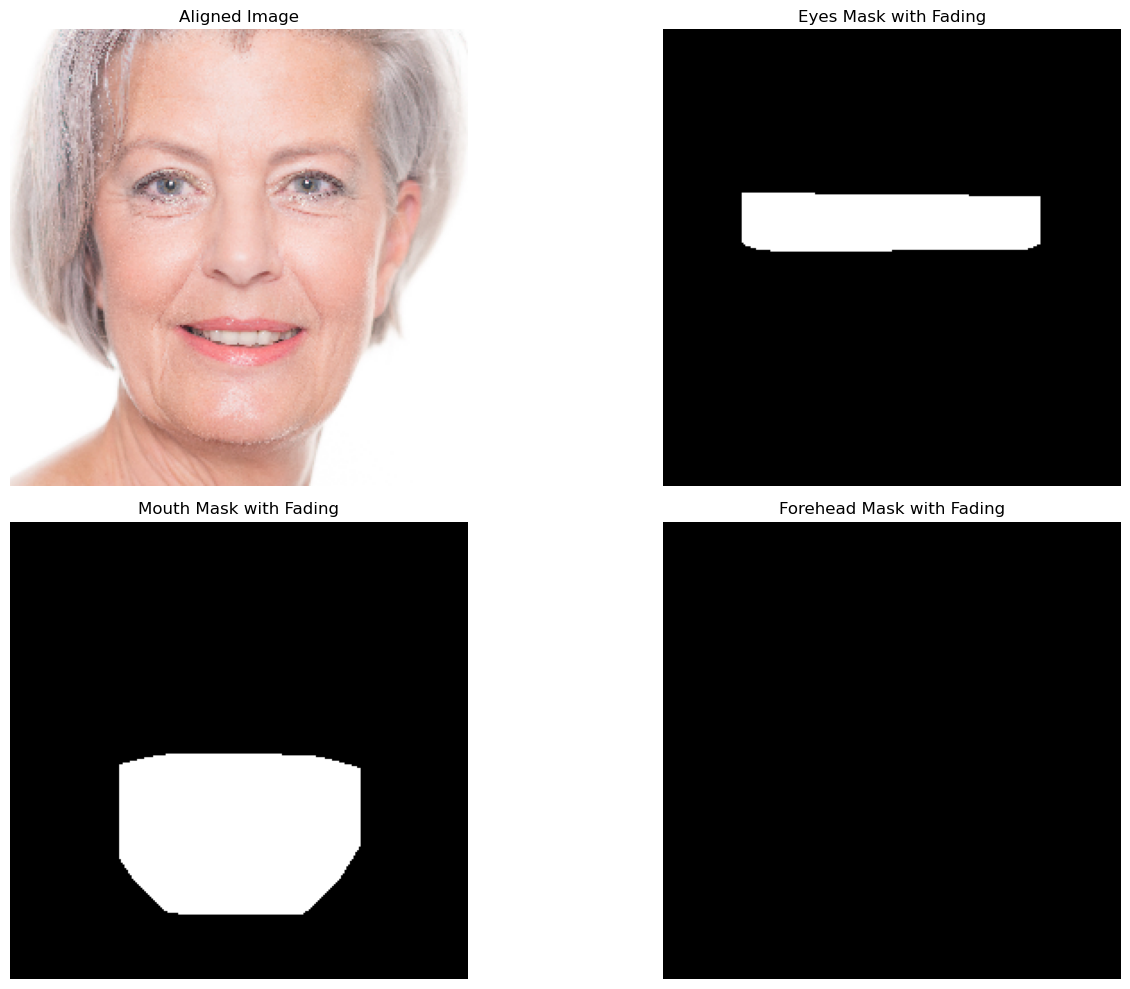

Inpainted image saved as 'output_masks\inpainted_face_cv2.png'


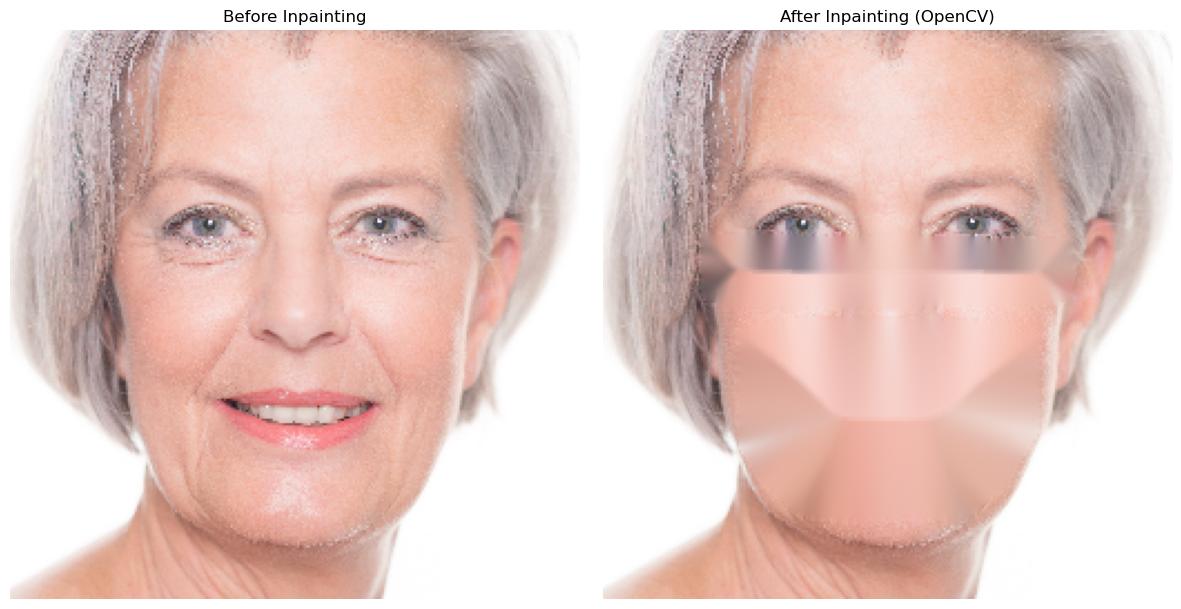

In [60]:
import cv2
import dlib
import numpy as np
import imutils
from imutils import face_utils
import math
import os
import matplotlib.pyplot as plt

# Suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore")

# ==========================
# Configuration Parameters
# ==========================

# Paths
PREDICTOR_PATH = 'shape_predictor_68_face_landmarks.dat'  # Ensure this file is in your working directory
IMAGE_PATH = '1 (2789).jpg'  # Replace with your image path
OUTPUT_DIR = 'output_masks'

# Inpainting Parameters
FADE_SIZE = 30
INPAINT_RADIUS = 3  # Radius for inpainting
INPAINT_METHOD = cv2.INPAINT_TELEA  # Choose between cv2.INPAINT_TELEA and cv2.INPAINT_NS

# ==========================
# Helper Functions
# ==========================

def align_face(image, landmarks):
    """
    Aligns the face in the image based on eye positions.
    """
    desired_left_eye = (0.35, 0.35)
    desired_face_width = 256
    desired_face_height = 256

    # Extract the left and right eye coordinates
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks[lStart:lEnd]
    rightEyePts = landmarks[rStart:rEnd]

    # Compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

    # Compute the angle between the eye centroids
    dy = rightEyeCenter[1] - leftEyeCenter[1]
    dx = rightEyeCenter[0] - leftEyeCenter[0]
    angle = math.degrees(math.atan2(dy, dx)) - 180

    # Compute the desired right eye x-coordinate based on desired left eye x-coordinate
    desired_right_eye_x = 1.0 - desired_left_eye[0]

    # Determine the scale of the new face
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = (desired_right_eye_x - desired_left_eye[0]) * desired_face_width
    scale = desired_dist / dist

    # Compute center between the two eyes
    eyes_center = ((leftEyeCenter[0] + rightEyeCenter[0]) / 2.0,
                   (leftEyeCenter[1] + rightEyeCenter[1]) / 2.0)

    # Get the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # Update the translation component of the matrix
    tX = desired_face_width * 0.5
    tY = desired_face_height * desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # Apply the affine transformation
    aligned_face = cv2.warpAffine(image, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)

    return aligned_face, M

def get_landmarks(aligned_image, M, original_landmarks):
    """
    Transforms the original landmarks to the aligned image's coordinate system.
    """
    ones = np.ones((original_landmarks.shape[0], 1))
    landmarks_homogeneous = np.hstack([original_landmarks, ones])
    transformed_landmarks = M.dot(landmarks_homogeneous.T).T
    return transformed_landmarks

def get_face_contour(aligned_image, landmarks_aligned):
    """
    Creates a mask for the facial contour using jawline landmarks.
    """
    contour_pts = landmarks_aligned[0:17].astype(int)  # Jawline points
    mask_contour = np.zeros(aligned_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask_contour, [contour_pts], 255)
    return mask_contour

def create_directional_constraint(shape, direction='down'):
    """
    Creates a directional constraint mask to control the direction of fading.
    """
    constraint = np.zeros(shape, dtype=np.uint8)
    h, w = shape

    if direction == 'down':
        constraint[h//2:h, :] = 255
    elif direction == 'up':
        constraint[0:h//2, :] = 255
    elif direction == 'left':
        constraint[:, 0:w//2] = 255
    elif direction == 'right':
        constraint[:, w//2:w] = 255
    elif direction in ['horizontal', 'vertical']:
        constraint[:, :] = 255
    else:
        constraint[:, :] = 255  # No constraint

    return constraint

def apply_directional_fade(mask, direction='down', fade_size=30):
    """
    Applies directional fading to a mask.
    """
    kernel = np.ones((3,3), np.uint8)
    faded_mask = mask.copy()

    for i in range(1, fade_size+1):
        dilated = cv2.dilate(mask, kernel, iterations=1)
        temp_mask = cv2.subtract(dilated, mask)
        weight = 1 - (i / (fade_size + 1))
        faded = (temp_mask.astype(float) * weight).astype(np.uint8)

        if direction in ['down', 'up']:
            directional_mask = create_directional_constraint(mask.shape, direction=direction)
            faded = cv2.bitwise_and(faded, directional_mask)

        faded_mask = cv2.max(faded_mask, faded)
        mask = dilated.copy()

    combined_mask = cv2.add(mask, faded_mask)
    combined_mask = cv2.normalize(combined_mask, None, 0, 255, cv2.NORM_MINMAX)

    return combined_mask

def create_fading_mask(aligned_image, landmarks_aligned, mask_contour, fade_size=30):
    """
    Creates fading masks for eyes and mouth.
    """
    mask_eye = np.zeros(aligned_image.shape[:2], dtype=np.uint8)
    mask_mouth = np.zeros(aligned_image.shape[:2], dtype=np.uint8)

    # Eyes
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks_aligned[lStart:lEnd].astype(int)
    rightEyePts = landmarks_aligned[rStart:rEnd].astype(int)

    cv2.fillPoly(mask_eye, [leftEyePts], 255)
    cv2.fillPoly(mask_eye, [rightEyePts], 255)

    # Mouth
    (mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
    mouthPts = landmarks_aligned[mStart:mEnd].astype(int)
    cv2.fillPoly(mask_mouth, [mouthPts], 255)

    # Apply directional fading
    mask_eye_faded = apply_directional_fade(mask_eye, direction='down', fade_size=fade_size)
    mask_mouth_faded = apply_directional_fade(mask_mouth, direction='down', fade_size=fade_size)

    # Ensure masks don't exceed facial boundaries
    mask_eye_faded = cv2.bitwise_and(mask_eye_faded, mask_contour)
    mask_mouth_faded = cv2.bitwise_and(mask_mouth_faded, mask_contour)

    return mask_eye_faded, mask_mouth_faded

def create_forehead_mask(aligned_image, landmarks_aligned, mask_contour, fade_size=30):
    """
    Creates a mask for the forehead region.
    """
    mask_forehead = np.zeros(aligned_image.shape[:2], dtype=np.uint8)

    # Eyebrow landmarks to approximate forehead
    (leStart, leEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
    (reStart, reEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
    left_eyebrow = landmarks_aligned[leStart:leEnd].astype(int)
    right_eyebrow = landmarks_aligned[reStart:reEnd].astype(int)

    # Center point between eyebrows
    eyebrows_center = ((left_eyebrow.mean(axis=0) + right_eyebrow.mean(axis=0)) / 2).astype(int)

    # Forehead rectangle parameters
    forehead_width = 80  # Adjust as needed
    forehead_height = 40  # Adjust as needed

    top_left = (int(eyebrows_center[0] - forehead_width / 2), int(eyebrows_center[1] - forehead_height - 10))
    bottom_right = (int(eyebrows_center[0] + forehead_width / 2), int(eyebrows_center[1] - 10))

    # Draw the forehead rectangle
    cv2.rectangle(mask_forehead, top_left, bottom_right, 255, -1)

    # Apply Gaussian blur to soften edges
    mask_forehead = cv2.GaussianBlur(mask_forehead, (21, 21), 0)

    # Ensure the forehead mask doesn't exceed facial boundaries
    mask_forehead = cv2.bitwise_and(mask_forehead, mask_contour)

    # Optionally, apply directional fading to the forehead
    mask_forehead_faded = apply_directional_fade(mask_forehead, direction='down', fade_size=fade_size)

    return mask_forehead_faded

def combine_masks(mask_eye, mask_mouth, mask_forehead):
    """
    Combines individual masks into a single mask.
    """
    combined_mask = cv2.bitwise_or(mask_eye, mask_mouth)
    combined_mask = cv2.bitwise_or(combined_mask, mask_forehead)
    return combined_mask

def save_masks(mask_eye_faded, mask_mouth_faded, mask_forehead_faded, combined_mask, output_dir='output_masks'):
    """
    Saves the individual and combined masks to the specified directory.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cv2.imwrite(os.path.join(output_dir, 'mask_eye_faded.png'), mask_eye_faded)
    cv2.imwrite(os.path.join(output_dir, 'mask_mouth_faded.png'), mask_mouth_faded)
    cv2.imwrite(os.path.join(output_dir, 'mask_forehead_faded.png'), mask_forehead_faded)
    cv2.imwrite(os.path.join(output_dir, 'combined_mask.png'), combined_mask)

    print(f"Masks saved in directory: '{output_dir}'")

def visualize_masks(aligned_image, mask_eye_faded, mask_mouth_faded, mask_forehead_faded):
    """
    Displays the aligned image and masks for verification.
    """
    aligned_image_rgb = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(aligned_image_rgb)
    plt.title('Aligned Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(mask_eye_faded, cmap='gray')
    plt.title('Eyes Mask with Fading')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(mask_mouth_faded, cmap='gray')
    plt.title('Mouth Mask with Fading')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(mask_forehead_faded, cmap='gray')
    plt.title('Forehead Mask with Fading')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def perform_inpainting_cv2(aligned_image, combined_mask, inpaint_radius=3, method=cv2.INPAINT_TELEA):
    """
    Performs inpainting using OpenCV's inpainting methods.
    """
    inpainted_image = cv2.inpaint(aligned_image, combined_mask, inpaint_radius, method)
    return inpainted_image

def save_inpainted_image(inpainted_image, output_dir='output_masks', filename='inpainted_face_cv2.png'):
    """
    Saves the inpainted image to the specified directory.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    inpainted_image_path = os.path.join(output_dir, filename)
    cv2.imwrite(inpainted_image_path, inpainted_image)
    print(f"Inpainted image saved as '{inpainted_image_path}'")

def show_before_after(aligned_image, inpainted_image):
    """
    Displays the original and inpainted images side by side.
    """
    aligned_image_rgb = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)
    inpainted_image_rgb = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(aligned_image_rgb)
    plt.title('Before Inpainting')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(inpainted_image_rgb)
    plt.title('After Inpainting (OpenCV)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ==========================
# Main Processing
# ==========================

def main():
    # Check if predictor file exists
    if not os.path.exists(PREDICTOR_PATH):
        raise FileNotFoundError(f"Facial landmark predictor not found at '{PREDICTOR_PATH}'. Please download it from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 and extract it.")

    # Load the image
    image = cv2.imread(IMAGE_PATH)
    if image is None:
        raise ValueError(f"Image not found or unable to load at '{IMAGE_PATH}'.")

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize dlib's face detector and facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(PREDICTOR_PATH)

    # Detect faces in the grayscale image
    rects = detector(gray, 1)
    if len(rects) == 0:
        raise ValueError("No faces detected in the image.")

    # Process the first detected face
    rect = rects[0]
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)  # Convert to NumPy array

    # Align the face
    aligned_image, transformation_matrix = align_face(image, shape)

    # Transform landmarks to aligned image
    landmarks_aligned = get_landmarks(aligned_image, transformation_matrix, shape)

    # Create face contour mask
    mask_contour = get_face_contour(aligned_image, landmarks_aligned)

    # Create masks for eyes and mouth with fading
    mask_eye_faded, mask_mouth_faded = create_fading_mask(aligned_image, landmarks_aligned, mask_contour, fade_size=FADE_SIZE)

    # Create mask for forehead with fading
    mask_forehead_faded = create_forehead_mask(aligned_image, landmarks_aligned, mask_contour, fade_size=FADE_SIZE)

    # Combine all masks
    combined_mask = combine_masks(mask_eye_faded, mask_mouth_faded, mask_forehead_faded)

    # Save the masks
    save_masks(mask_eye_faded, mask_mouth_faded, mask_forehead_faded, combined_mask, output_dir=OUTPUT_DIR)

    # Visualize the masks
    visualize_masks(aligned_image, mask_eye_faded, mask_mouth_faded, mask_forehead_faded)

    # Perform inpainting using OpenCV
    inpainted_image_cv2 = perform_inpainting_cv2(aligned_image, combined_mask, inpaint_radius=INPAINT_RADIUS, method=INPAINT_METHOD)

    # Save the inpainted image
    save_inpainted_image(inpainted_image_cv2, output_dir=OUTPUT_DIR, filename='inpainted_face_cv2.png')

    # Show before and after images
    show_before_after(aligned_image, inpainted_image_cv2)

if __name__ == "__main__":
    main()


In [64]:
import requests
import json

url = "https://modelslab.com/api/v6/image_editing/inpaint"

payload = json.dumps({
  "key": "",
  "prompt": "a cat sitting on a bench",
  "negative_prompt": None,
  "init_image": "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png",
  "mask_image": "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png",
  "width": "512",
  "height": "512",
  "samples": "1",
  "num_inference_steps": "30",
  "safety_checker": "no",
  "enhance_prompt": "yes",
  "guidance_scale": 5,
  "strength": 0.7,
  "seed": None,
  "webhook": None,
  "track_id": None
})

headers = {
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)

In [69]:
import cv2
import dlib
import numpy as np
import math
from imutils import face_utils
import requests
import json
import base64

# Ensure these files are in your working directory
PREDICTOR_PATH = 'shape_predictor_68_face_landmarks.dat'  # Dlib's pre-trained shape predictor
IMAGE_PATH = '1 (2789).jpg'  # Replace with your image path
API_KEY = 'YOUR_API_KEY'  # Replace with your ModelsLab API key

def align_face(image, landmarks):
    """
    Aligns the face in the image based on eye positions.
    Returns the aligned face and the transformation matrix.
    """
    desired_left_eye = (0.35, 0.35)
    desired_face_width = 512
    desired_face_height = 512

    # Extract the left and right eye coordinates
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks[lStart:lEnd]
    rightEyePts = landmarks[rStart:rEnd]

    # Compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

    # Compute the angle between the eye centroids
    dy = rightEyeCenter[1] - leftEyeCenter[1]
    dx = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dy, dx)) - 180

    # Compute the desired right eye x-coordinate based on desired left eye x-coordinate
    desired_right_eye_x = 1.0 - desired_left_eye[0]

    # Determine the scale of the new face
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = (desired_right_eye_x - desired_left_eye[0]) * desired_face_width
    scale = desired_dist / dist

    # Compute center between the two eyes
    eyes_center = ((leftEyeCenter[0] + rightEyeCenter[0]) / 2.0,
                   (leftEyeCenter[1] + rightEyeCenter[1]) / 2.0)

    # Get the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # Update the translation component of the matrix
    tX = desired_face_width * 0.5
    tY = desired_face_height * desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # Apply the affine transformation
    aligned_face = cv2.warpAffine(image, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)

    return aligned_face, M

def create_full_face_mask(aligned_face, landmarks, M):
    """
    Creates a mask of the whole face in the aligned image using the convex hull of all landmarks.
    """
    # Reshape landmarks for cv2.transform
    landmarks = landmarks.reshape(-1, 1, 2).astype(np.float32)  # Shape (68, 1, 2)

    # Apply the transformation matrix to the landmarks
    transformed_landmarks = cv2.transform(landmarks, M)
    transformed_landmarks = transformed_landmarks.reshape(-1, 2)

    # Convert landmarks to integer coordinates
    landmarks_aligned = transformed_landmarks.astype(np.int32)

    # Use the convex hull of all facial landmarks
    hull = cv2.convexHull(landmarks_aligned)

    # Create an empty mask
    mask = np.zeros(aligned_face.shape[:2], dtype=np.uint8)

    # Fill the convex hull in the mask
    cv2.fillConvexPoly(mask, hull, 255)

    return mask

def encode_image_to_base64(image):
    """
    Encodes an image to a base64 string.
    """
    _, buffer = cv2.imencode('.png', image)
    img_base64 = base64.b64encode(buffer).decode('utf-8')
    return img_base64

def inpaint_with_api(aligned_face, face_mask):
    """
    Sends a request to the ModelsLab API to inpaint the image using the given mask.
    """
    url = "https://modelslab.com/api/v6/image_editing/inpaint"

    # Encode images to base64
    init_image_base64 = encode_image_to_base64(aligned_face)
    mask_image_base64 = encode_image_to_base64(face_mask)

    payload = json.dumps({
        "key": 'nFZoH6cvaDHm3Ns6aCUckBvM7bIs6hZ3l0me5sOIU0X3Wapj6Irv8kH9W0xj',
        "prompt": "smooth skin, remove wrinkles",
        "negative_prompt": None,
        "init_image": init_image_base64,
        "mask_image": mask_image_base64,
        "width": str(aligned_face.shape[1]),
        "height": str(aligned_face.shape[0]),
        "samples": "1",
        "num_inference_steps": "30",
        "safety_checker": "no",
        "enhance_prompt": "yes",
        "guidance_scale": 7.5,
        "strength": 0.75,
        "seed": None,
        "webhook": None,
        "track_id": None
    })

    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    
    if response.status_code == 200:
        result = response.json()
        # Assuming the API returns the edited image as a base64 string in 'output'
        if 'output' in result:
            output_base64 = result['output'][0]
            # Decode the base64 string back to an image
            output_image_data = base64.b64decode(output_base64)
            nparr = np.frombuffer(output_image_data, np.uint8)
            output_image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            return output_image
        else:
            print("Error: 'output' not found in API response.")
            return None
    else:
        print(f"Error: API request failed with status code {response.status_code}")
        print("Response:", response.text)
        return None

def main():
    # Load the image
    image = cv2.imread(IMAGE_PATH)
    if image is None:
        print(f"Error: Could not read image {IMAGE_PATH}")
        return

    # Initialize dlib's face detector and shape predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(PREDICTOR_PATH)

    # Detect faces in the image
    rects = detector(image, 1)
    if len(rects) == 0:
        print("Error: No faces detected")
        return

    # Process the first detected face
    rect = rects[0]

    # Get facial landmarks
    shape = predictor(image, rect)
    landmarks = face_utils.shape_to_np(shape)

    # Align the face
    aligned_face, M = align_face(image, landmarks)

    # Create a mask of the whole face using the convex hull
    face_mask = create_full_face_mask(aligned_face, landmarks, M)

    # Inpaint using the API
    output_image = inpaint_with_api(aligned_face, face_mask)

    if output_image is not None:
        # Save the outputs
        cv2.imwrite('aligned_face.jpg', aligned_face)
        cv2.imwrite('face_mask.jpg', face_mask)
        cv2.imwrite('smooth_skin_face.jpg', output_image)

        # Display the results
        cv2.imshow('Aligned Face', aligned_face)
        cv2.imshow('Face Mask', face_mask)
        cv2.imshow('Smooth Skin Face', output_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Inpainting failed.")

if __name__ == "__main__":
    main()


Error: 'output' not found in API response.
Inpainting failed.


In [72]:
import cv2
import dlib
import numpy as np
import math
from imutils import face_utils
import requests
import json
import base64

# Ensure these files are in your working directory
PREDICTOR_PATH = 'shape_predictor_68_face_landmarks.dat'  # Dlib's pre-trained shape predictor
IMAGE_PATH = '1 (2789).jpg'  # Replace with your image path
API_KEY = 'nFZoH6cvaDHm3Ns6aCUckBvM7bIs6hZ3l0me5sOIU0X3Wapj6Irv8kH9W0xj'  # Replace with your ModelsLab API key

def align_face(image, landmarks):
    """
    Aligns the face in the image based on eye positions.
    Returns the aligned face and the transformation matrix.
    """
    desired_left_eye = (0.35, 0.35)
    desired_face_width = 512
    desired_face_height = 512

    # Extract the left and right eye coordinates
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks[lStart:lEnd]
    rightEyePts = landmarks[rStart:rEnd]

    # Compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

    # Compute the angle between the eye centroids
    dy = rightEyeCenter[1] - leftEyeCenter[1]
    dx = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dy, dx)) - 180

    # Compute the desired right eye x-coordinate based on desired left eye x-coordinate
    desired_right_eye_x = 1.0 - desired_left_eye[0]

    # Determine the scale of the new face
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = (desired_right_eye_x - desired_left_eye[0]) * desired_face_width
    scale = desired_dist / dist

    # Compute center between the two eyes
    eyes_center = ((leftEyeCenter[0] + rightEyeCenter[0]) / 2.0,
                   (leftEyeCenter[1] + rightEyeCenter[1]) / 2.0)

    # Get the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # Update the translation component of the matrix
    tX = desired_face_width * 0.5
    tY = desired_face_height * desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # Apply the affine transformation
    aligned_face = cv2.warpAffine(image, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)

    return aligned_face, M

def create_full_face_mask(aligned_face, landmarks, M):
    """
    Creates a mask of the whole face in the aligned image using the convex hull of all landmarks.
    """
    # Reshape landmarks for cv2.transform
    landmarks = landmarks.reshape(-1, 1, 2).astype(np.float32)  # Shape (68, 1, 2)

    # Apply the transformation matrix to the landmarks
    transformed_landmarks = cv2.transform(landmarks, M)
    transformed_landmarks = transformed_landmarks.reshape(-1, 2)

    # Convert landmarks to integer coordinates
    landmarks_aligned = transformed_landmarks.astype(np.int32)

    # Use the convex hull of all facial landmarks
    hull = cv2.convexHull(landmarks_aligned)

    # Create an empty mask
    mask = np.zeros(aligned_face.shape[:2], dtype=np.uint8)

    # Fill the convex hull in the mask
    cv2.fillConvexPoly(mask, hull, 255)

    return mask

def encode_image_to_base64(image):
    """
    Encodes an image to a base64 string.
    """
    _, buffer = cv2.imencode('.png', image)
    img_base64 = base64.b64encode(buffer).decode('utf-8')
    return img_base64

def inpaint_with_api(aligned_face, face_mask):
    """
    Sends a request to the ModelsLab API to inpaint the image using the given mask.
    """
    url = "https://modelslab.com/api/v6/image_editing/inpaint"

    # Encode images to base64
    init_image_base64 = encode_image_to_base64(aligned_face)
    mask_image_base64 = encode_image_to_base64(face_mask)

    payload = json.dumps({
        "key": API_KEY,
        "prompt": "smooth skin, remove wrinkles",
        "negative_prompt": None,
        "init_image": init_image_base64,
        "mask_image": mask_image_base64,
        "width": str(aligned_face.shape[1]),
        "height": str(aligned_face.shape[0]),
        "samples": "1",
        "num_inference_steps": "30",
        "safety_checker": False,
        "enhance_prompt": True,
        "guidance_scale": 7.5,
        "strength": 0.75,
        "seed": None,
        "webhook": None,
        "track_id": None
    })

    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.post(url, headers=headers, data=payload)

    if response.status_code == 200:
        result = response.json()
        # The API returns the edited image as a URL in 'output'
        if 'output' in result:
            output_url = result['output'][0]
            # Download the image from the URL
            img_response = requests.get(output_url)
            if img_response.status_code == 200:
                nparr = np.frombuffer(img_response.content, np.uint8)
                output_image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                return output_image
            else:
                print(f"Error: Failed to download image from {output_url}")
                return None
        else:
            print("Error: 'output' not found in API response.")
            print("Response:", result)
            return None
    else:
        print(f"Error: API request failed with status code {response.status_code}")
        print("Response:", response.text)
        return None

def main():
    # Load the image
    image = cv2.imread(IMAGE_PATH)
    if image is None:
        print(f"Error: Could not read image {IMAGE_PATH}")
        return

    # Initialize dlib's face detector and shape predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(PREDICTOR_PATH)

    # Detect faces in the image
    rects = detector(image, 1)
    if len(rects) == 0:
        print("Error: No faces detected")
        return

    # Process the first detected face
    rect = rects[0]

    # Get facial landmarks
    shape = predictor(image, rect)
    landmarks = face_utils.shape_to_np(shape)

    # Align the face
    aligned_face, M = align_face(image, landmarks)

    # Create a mask of the whole face using the convex hull
    face_mask = create_full_face_mask(aligned_face, landmarks, M)

    # Inpaint using the API
    output_image = inpaint_with_api(aligned_face, face_mask)

    if output_image is not None:
        # Save the outputs
        cv2.imwrite('aligned_face.jpg', aligned_face)
        cv2.imwrite('face_mask.jpg', face_mask)
        cv2.imwrite('smooth_skin_face.jpg', output_image)

        # Display the before and after images side by side
        before_and_after = np.hstack((aligned_face, output_image))
        cv2.imshow('Before and After', before_and_after)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Inpainting failed.")

if __name__ == "__main__":
    main()


Error: 'output' not found in API response.
Response: {'status': 'error', 'message': 'The selected safety checker is invalid.'}
Inpainting failed.


In [73]:
import cv2
import dlib
import numpy as np
import math
from imutils import face_utils
import requests
import json
import base64

# Ensure these files are in your working directory
PREDICTOR_PATH = 'shape_predictor_68_face_landmarks.dat'  # Dlib's pre-trained shape predictor
IMAGE_PATH = '1 (2789).jpg'  # Replace with your image path
API_KEY = 'nFZoH6cvaDHm3Ns6aCUckBvM7bIs6hZ3l0me5sOIU0X3Wapj6Irv8kH9W0xj'  # Replace with your ModelsLab API key

def align_face(image, landmarks):
    """
    Aligns the face in the image based on eye positions.
    Returns the aligned face and the transformation matrix.
    """
    desired_left_eye = (0.35, 0.35)
    desired_face_width = 512
    desired_face_height = 512

    # Extract the left and right eye coordinates
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = landmarks[lStart:lEnd]
    rightEyePts = landmarks[rStart:rEnd]

    # Compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

    # Compute the angle between the eye centroids
    dy = rightEyeCenter[1] - leftEyeCenter[1]
    dx = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dy, dx)) - 180

    # Compute the desired right eye x-coordinate based on desired left eye x-coordinate
    desired_right_eye_x = 1.0 - desired_left_eye[0]

    # Determine the scale of the new face
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = (desired_right_eye_x - desired_left_eye[0]) * desired_face_width
    scale = desired_dist / dist

    # Compute center between the two eyes
    eyes_center = ((leftEyeCenter[0] + rightEyeCenter[0]) / 2.0,
                   (leftEyeCenter[1] + rightEyeCenter[1]) / 2.0)

    # Get the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # Update the translation component of the matrix
    tX = desired_face_width * 0.5
    tY = desired_face_height * desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # Apply the affine transformation
    aligned_face = cv2.warpAffine(image, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)

    return aligned_face, M

def create_full_face_mask(aligned_face, landmarks, M):
    """
    Creates a mask of the whole face in the aligned image using the convex hull of all landmarks.
    """
    # Reshape landmarks for cv2.transform
    landmarks = landmarks.reshape(-1, 1, 2).astype(np.float32)  # Shape (68, 1, 2)

    # Apply the transformation matrix to the landmarks
    transformed_landmarks = cv2.transform(landmarks, M)
    transformed_landmarks = transformed_landmarks.reshape(-1, 2)

    # Convert landmarks to integer coordinates
    landmarks_aligned = transformed_landmarks.astype(np.int32)

    # Use the convex hull of all facial landmarks
    hull = cv2.convexHull(landmarks_aligned)

    # Create an empty mask
    mask = np.zeros(aligned_face.shape[:2], dtype=np.uint8)

    # Fill the convex hull in the mask
    cv2.fillConvexPoly(mask, hull, 255)

    return mask

def encode_image_to_base64(image):
    """
    Encodes an image to a base64 string.
    """
    _, buffer = cv2.imencode('.png', image)
    img_base64 = base64.b64encode(buffer).decode('utf-8')
    return img_base64

def inpaint_with_api(aligned_face, face_mask):
    """
    Sends a request to the ModelsLab API to inpaint the image using the given mask.
    """
    url = "https://modelslab.com/api/v6/image_editing/inpaint"

    # Encode images to base64
    init_image_base64 = encode_image_to_base64(aligned_face)
    mask_image_base64 = encode_image_to_base64(face_mask)

    payload = json.dumps({
        "key": API_KEY,
        "prompt": "smooth skin, remove wrinkles",
        "negative_prompt": None,
        "init_image": init_image_base64,
        "mask_image": mask_image_base64,
        "width": str(aligned_face.shape[1]),
        "height": str(aligned_face.shape[0]),
        "samples": "1",
        "num_inference_steps": "30",
        "safety_checker": "no",
        "enhance_prompt": "yes",
        "guidance_scale": 7.5,
        "strength": 0.75,
        "seed": None,
        "webhook": None,
        "track_id": None
    })

    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    
    if response.status_code == 200:
        result = response.json()
        # Assuming the API returns the edited image as a base64 string in 'output'
        if 'output' in result:
            output_base64 = result['output'][0]
            # Decode the base64 string back to an image
            output_image_data = base64.b64decode(output_base64)
            nparr = np.frombuffer(output_image_data, np.uint8)
            output_image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            return output_image
        else:
            print("Error: 'output' not found in API response.")
            return None
    else:
        print(f"Error: API request failed with status code {response.status_code}")
        print("Response:", response.text)
        return None

def main():
    # Load the image
    image = cv2.imread(IMAGE_PATH)
    if image is None:
        print(f"Error: Could not read image {IMAGE_PATH}")
        return

    # Initialize dlib's face detector and shape predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(PREDICTOR_PATH)

    # Detect faces in the image
    rects = detector(image, 1)
    if len(rects) == 0:
        print("Error: No faces detected")
        return

    # Process the first detected face
    rect = rects[0]

    # Get facial landmarks
    shape = predictor(image, rect)
    landmarks = face_utils.shape_to_np(shape)

    # Align the face
    aligned_face, M = align_face(image, landmarks)

    # Create a mask of the whole face using the convex hull
    face_mask = create_full_face_mask(aligned_face, landmarks, M)

    # Inpaint using the API
    output_image = inpaint_with_api(aligned_face, face_mask)

    if output_image is not None:
        # Save the outputs
        cv2.imwrite('aligned_face.jpg', aligned_face)
        cv2.imwrite('face_mask.jpg', face_mask)
        cv2.imwrite('smooth_skin_face.jpg', output_image)

        # Display the results
        cv2.imshow('Aligned Face', aligned_face)
        cv2.imshow('Face Mask', face_mask)
        cv2.imshow('Smooth Skin Face', output_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Inpainting failed.")

if __name__ == "__main__":
    main()


Error: 'output' not found in API response.
Inpainting failed.
